In [1]:
import os
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import accuracy_score

from PIL import Image 

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn 
import torch.optim as optim 
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, RandomResizedCrop, RandomHorizontalFlip, RandomVerticalFlip;
from torchvision.utils import make_grid

In [2]:
#select device
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

In [3]:
# uplode data
df = pd.read_csv("/kaggle/input/fer2013/fer2013.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [4]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [6]:
df.shape

(35887, 3)

In [7]:
class FER_Df(torch.utils.data.Dataset):
  def __init__(self, file_addr):
    super().__init__()
    pd_dataset = pd.read_csv(file_addr)

    self.numpy_dataset = np.array(pd_dataset, dtype=np.float32)


  def __len__(self):
    return len(self.numpy_dataset)

  def __getitem__(self, index):

    X = self.numpy_dataset[index, 1:]
    Y = self.numpy_dataset[index, 0]


    return X, Y

In [8]:
class FER_CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.ModuleList()

    self.layers.append(nn.Linear(35884, 2048))
    self.layers.append(nn.Linear(2048, 512))
    self.layers.append(nn.Linear(512, 128))
    self.layers.append(nn.Linear(128, 3))

    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)

    x = self.softmax(x)
    return x

In [9]:
# Separating test and training data
df_pub_test = df[df.Usage=="PublicTest"]
df_pri_test = df[df.Usage=="PrivateTest"]
df = df[df.Usage=="Training"]

In [10]:
lengths = [len(pix.split()) for pix in df.pixels]
print(set(lengths))

{2304}


In [11]:
emotions = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'}

emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotions)
emotion_counts

,emotion,number
0,Angry,3995
1,Fear,4097
2,Sad,4830
3,Neutral,4965
4,Happy,7215
5,Surprise,3171
6,Disgust,436


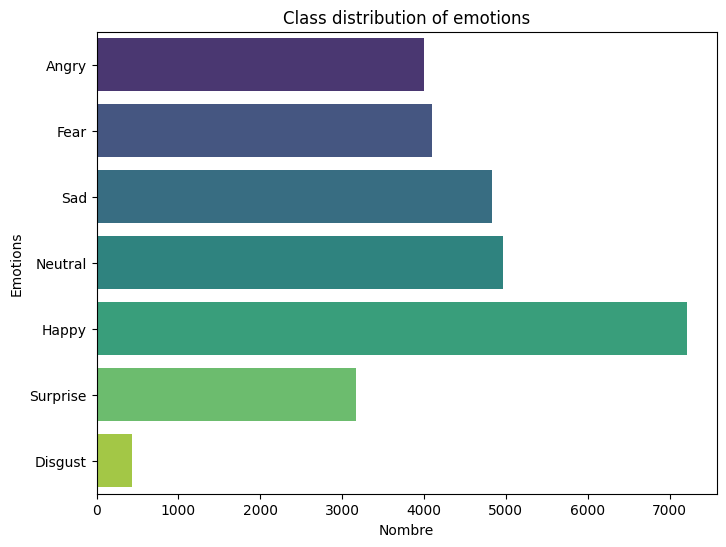

In [12]:
# Displaying sentiment distribution data using a bar chart
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotions)
plt.figure(figsize=(8, 6))
sns.barplot(x='number', y='emotion', data=emotion_counts, palette='viridis')
plt.title('Class distribution of emotions')
plt.xlabel('Nombre')
plt.ylabel('Emotions')
plt.show()

In [13]:
class DER_Df(torch.utils.data.Dataset):
  def __init__(self, file_addr):
    super().__init__()
    pd_dataset = pd.read_csv(file_addr)

    self.numpy_dataset = np.array(pd_dataset, dtype=np.float32)


  def __len__(self):
    return len(self.numpy_dataset)

  def __getitem__(self, index):

    X = self.numpy_dataset[index, 1:]
    Y = self.numpy_dataset[index, 0]


    return X, Y

Happy


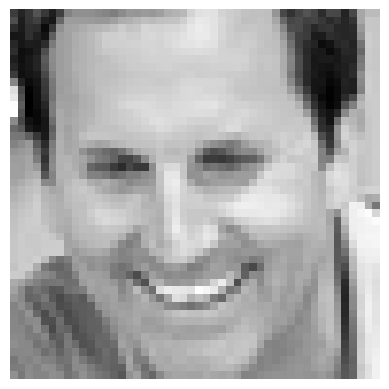

In [14]:
def show_dfinstance(index):
    image = np.array(df.at[index, "pixels"].split(" "), dtype="float32")
    
    image -= np.mean(image)
    image /= np.std(image)
    
    print(emotions[df.at[index, "emotion"]])
    
    image = image.reshape(48, 48)
    
    plt.imshow(image, cmap="gray")
    plt.axis('off')
    plt.show()  

show_dfinstance(np.random.randint(90, len(df)))